In [1]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
import random
from scipy.stats import norm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from copy import copy

pd.set_option('display.max_rows', 500)

In [2]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null and b.is_qa = false;
"""
df = rds_access_utils.extract_from_database(query)

In [3]:
blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

df = df[~df.id.isin(blacklisted_keypoint_annotation_ids) & (df.captured_at <= '2019-09-10')]

<h1> Apend world keypoints to this data </h1>

In [4]:
def get_world_keypoints(row):
    if 'leftCrop' in row.keypoints and 'rightCrop' in row.keypoints:
        return pixel2world(row.keypoints['leftCrop'], row.keypoints['rightCrop'], row.camera_metadata)
    else:
        return None
    
df['world_keypoints'] = df.apply(
    lambda x: get_world_keypoints(x), axis=1
)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/aquabyte/optics.py:36: RuntimeWarning: divide by zero encountered in true_divide
  depth = focal_length_pixel * baseline / np.array(disp)


In [5]:
def _generate_rotation_matrix(u_base, v):
    u = v / np.linalg.norm(v)
    n = np.cross(u_base, u)
    n = n / np.linalg.norm(n)
    theta = -np.arccos(np.dot(u, u_base))

    R = np.array([[
        np.cos(theta) + n[0]**2*(1-np.cos(theta)), 
        n[0]*n[1]*(1-np.cos(theta)) - n[2]*np.sin(theta),
        n[0]*n[2]*(1-np.cos(theta)) + n[1]*np.sin(theta)
    ], [
        n[1]*n[0]*(1-np.cos(theta)) + n[2]*np.sin(theta),
        np.cos(theta) + n[1]**2*(1-np.cos(theta)),
        n[1]*n[2]*(1-np.cos(theta)) - n[0]*np.sin(theta),
    ], [
        n[2]*n[0]*(1-np.cos(theta)) - n[1]*np.sin(theta),
        n[2]*n[1]*(1-np.cos(theta)) + n[0]*np.sin(theta),
        np.cos(theta) + n[2]**2*(1-np.cos(theta))
    ]])
    
    return R

def _normalize_world_keypoints(wkps, rotate=True):
    body_parts = wkps.keys()
    
    # translate keypoints such that tail notch is at origin
    if wkps['UPPER_LIP'][0] > wkps['HYPURAL_PLATE'][0]:
        front_bp, back_bp = 'UPPER_LIP', 'HYPURAL_PLATE'
    else:
        front_bp, back_bp = 'HYPURAL_PLATE', 'UPPER_LIP'
        
    translated_wkps = {bp: wkps[bp] - wkps[back_bp] for bp in body_parts}

    if not rotate:
        return translated_wkps
    
    # perform first rotation
    u_base=np.array([1, 0, 0])
    v = translated_wkps[front_bp]
    R = _generate_rotation_matrix(u_base, v)
    norm_wkps_intermediate = {bp: np.dot(R, translated_wkps[bp]) for bp in body_parts}
    
    return norm_wkps_intermediate

In [6]:
BODY_PARTS = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])


In [7]:
gtsf_fish_identifiers = list(df.fish_id.unique())
train_size = int(0.8 * len(gtsf_fish_identifiers))
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
# train_mask = df.fish_id.isin(fish_ids)
train_mask = (df.captured_at < '2019-09-01')



In [8]:
def well_behaved(wkps, cutoff_depth=10.0):
    if any([abs(wkp[1]) > cutoff_depth for wkp in wkps.values()]):
        return False
    return True
    

def flip_center_kps(left_kps, right_kps):
    
    x_min_l = min([kp[0] for kp in left_kps.values()])
    x_max_l = max([kp[0] for kp in left_kps.values()])
    x_mid_l = np.mean([x_min_l, x_max_l])
    
    y_min_l = min([kp[1] for kp in left_kps.values()])
    y_max_l = max([kp[1] for kp in left_kps.values()])
    y_mid_l = np.mean([y_min_l, y_max_l])
    
    x_min_r = min([kp[0] for kp in right_kps.values()])
    x_max_r = max([kp[0] for kp in right_kps.values()])
    x_mid_r = np.mean([x_min_r, x_max_r])
    
    y_min_r = min([kp[1] for kp in right_kps.values()])
    y_max_r = max([kp[1] for kp in right_kps.values()])
    y_mid_r = np.mean([y_min_r, y_max_r])
        
    fc_left_kps, fc_right_kps = {}, {}
    flip_factor = 1 if left_kps['UPPER_LIP'][0] > left_kps['TAIL_NOTCH'][0] else -1
    for bp in BODY_PARTS:
        left_kp, right_kp = left_kps[bp], right_kps[bp]
        if flip_factor > 0:
            fc_left_kp = np.array([left_kp[0] - x_mid_l, left_kp[1] - y_mid_l])
            fc_right_kp = np.array([right_kp[0] - x_mid_l, right_kp[1] - y_mid_l])
        else:
            fc_right_kp = np.array([x_mid_r - left_kp[0], left_kp[1] - y_mid_r])
            fc_left_kp = np.array([x_mid_r - right_kp[0], right_kp[1] - y_mid_r])
        fc_left_kps[bp] = fc_left_kp
        fc_right_kps[bp] = fc_right_kp
        
    return fc_left_kps, fc_right_kps


def _rotate_cc(p, theta):
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    rotated_kp = np.dot(R, p)
    return rotated_kp


def rotate_kps(left_kps, right_kps):
    upper_lip_x, upper_lip_y = left_kps['UPPER_LIP']
    theta = np.arctan(upper_lip_y / upper_lip_x)
    r_left_kps, r_right_kps = {}, {}
    for bp in BODY_PARTS:
        rotated_kp = _rotate_cc(left_kps[bp], -theta)
        r_left_kps[bp] = rotated_kp
        disp = abs(left_kps[bp][0] - right_kps[bp][0])
        r_right_kps[bp] = np.array([rotated_kp[0] - disp, rotated_kp[1]])
        
    return r_left_kps, r_right_kps


def translate_kps(left_kps, right_kps, factor):
    t_left_kps, t_right_kps = {}, {}
    for bp in BODY_PARTS:
        left_kp, right_kp = left_kps[bp], right_kps[bp]
        t_left_kps[bp] = factor * np.array(left_kps[bp])
        t_right_kps[bp] = factor * np.array(right_kps[bp])
    
    return t_left_kps, t_right_kps


def jitter_kps(left_kps, right_kps, jitter):
    j_left_kps, j_right_kps = {}, {}
    for bp in BODY_PARTS:
        j_left_kps[bp] = np.array([left_kps[bp][0] + np.random.normal(0, jitter), 
                                   left_kps[bp][1] + np.random.normal(0, jitter)])
        j_right_kps[bp] = np.array([right_kps[bp][0] + np.random.normal(0, jitter), 
                                    right_kps[bp][1] + np.random.normal(0, jitter)])
    
    return j_left_kps, j_right_kps



def modify_kps(left_kps, right_kps, factor, jitter, cm):
    fc_left_kps, fc_right_kps = flip_center_kps(left_kps, right_kps)
    r_left_kps, r_right_kps = rotate_kps(fc_left_kps, fc_right_kps)
    t_left_kps, t_right_kps = translate_kps(r_left_kps, r_right_kps, factor)
    j_left_kps, j_right_kps  = jitter_kps(t_left_kps, t_right_kps, jitter)
    j_left_kps_list, j_right_kps_list = [], []
    for bp in BODY_PARTS:
        l_item = {
            'keypointType': bp,
            'xFrame': j_left_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
            'yFrame': j_left_kps[bp][1] + cm['pixelCountHeight'] / 2.0
        }
        
        r_item = {
            'keypointType': bp,
            'xFrame': j_right_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
            'yFrame': j_right_kps[bp][1] + cm['pixelCountHeight'] / 2.0
        }
        
        j_left_kps_list.append(l_item)
        j_right_kps_list.append(r_item)
        
    modified_kps = {
        'leftCrop': j_left_kps_list,
        'rightCrop': j_right_kps_list
    }
    
    return modified_kps


def process_row(row, n_factors=1, jitters=[0], low=0.3, high=2.5, oos=False, network=None):
    X_row, labels_row, est_weights = [], [], []
    keypoints = row.keypoints
    left_keypoints_list = keypoints.get('leftCrop')
    right_keypoints_list = keypoints.get('rightCrop')
    cm = row.camera_metadata
    
    if left_keypoints_list and right_keypoints_list:
        wkps = pixel2world(left_keypoints_list, right_keypoints_list, cm)
        left_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in left_keypoints_list}
        right_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in right_keypoints_list}
        if well_behaved(wkps):
            for n in range(n_factors):
                factor = 1.0 if n_factors == 1 else np.random.uniform(low=low, high=high)
                for jitter in jitters:
                    trials = 3 if jitter > 0 else 1
                    for t in range(trials):
                        modified_kps = modify_kps(left_kps, right_kps, factor, jitter, cm)
                        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
                        data_point = []
                        for bp in BODY_PARTS:
                            wkp = modified_wkps[bp]
                            data_point.append([wkp[0] / wkp[1], wkp[2] / wkp[1], 0.1 / wkp[1]])
                        X_row.append(data_point)
                        if not oos:
                            labels_row.append(row.weight)
                        if network:
                            u = torch.from_numpy(np.array(data_point) / 2.0).float()
                            est_weights.append(network(u.view(1, *u.shape)).item())

    return X_row, labels_row, est_weights




In [214]:
for ix, row in tdf[tdf.index == tdf.index[0]].iterrows():
    X_row, labels_row, est_weights = process_row(row, n_factors=1, jitters=[0], network=network)


In [239]:
for ix, row in tdf[tdf.index == tdf.index[68]].iterrows():
    X_row, labels_row, est_weights = process_row(row, n_factors=1, jitters=[0], network=network)


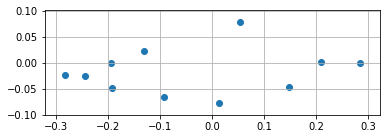

In [240]:
%matplotlib inline
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(X_row[0])[:, 0], np.array(X_row[0])[:, 1])
plt.grid()
plt.show()

In [263]:
body_parts

['ADIPOSE_FIN',
 'ANAL_FIN',
 'DORSAL_FIN',
 'EYE',
 'HYPURAL_PLATE',
 'LOWER_PRECAUDAL_PIT',
 'PECTORAL_FIN',
 'PELVIC_FIN',
 'TAIL_NOTCH',
 'UPPER_LIP',
 'UPPER_PRECAUDAL_PIT']

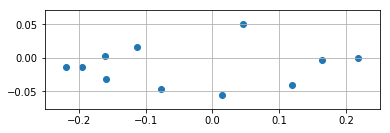

In [234]:
%matplotlib inline
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(X[74620])[:, 0], np.array(X[74620])[:, 1])
plt.grid()
plt.show()

In [241]:
X[74620]

array([[-0.11235386,  0.0167675 ,  0.08802917],
       [-0.07673577, -0.04623427,  0.09124975],
       [ 0.04571618,  0.05056594,  0.09643846],
       [ 0.16339663, -0.00274036,  0.11987712],
       [-0.19525136, -0.01313196,  0.0865978 ],
       [-0.15941391, -0.03139863,  0.08820809],
       [ 0.11917639, -0.04128837,  0.11128891],
       [ 0.01479365, -0.05580871,  0.09625954],
       [-0.219385  , -0.01359831,  0.0857032 ],
       [ 0.21820867,  0.        ,  0.12703396],
       [-0.16013562,  0.00245782,  0.08981838]])

In [264]:
X_t[68]

array([[-0.06555286,  0.01113656,  0.05035907],
       [-0.04584279, -0.03322679,  0.05219253],
       [ 0.02716564,  0.03893118,  0.05744845],
       [ 0.10509454,  0.00072068,  0.07211614],
       [-0.12227116, -0.01303298,  0.0520703 ],
       [-0.09572808, -0.02402497,  0.05268145],
       [ 0.0743392 , -0.02325546,  0.06844922],
       [ 0.00699615, -0.03867671,  0.05695953],
       [-0.1417809 , -0.012308  ,  0.05145915],
       [ 0.14187244,  0.        ,  0.07321622],
       [-0.09702271, -0.00028757,  0.05084799]])

In [265]:
.1 / .0857

1.1668611435239207

In [266]:
.219 / 1.1668

0.18769283510455947

In [267]:
.1 / .05145

1.9436345966958213

In [268]:
.1417 / 1.943

0.07292846114256304

In [258]:
df[df.weight == 1500].data.iloc[0]

{'species': 'salmon',
 'location': 'Bremnes',
 'widthMms': 113,
 'lengthMms': 515,
 'penNumber': '0',
 'weightKgs': 1500,
 'breadthMms': 61}

In [262]:
tdf.data.iloc[68]

{'species': 'salmon',
 'location': 'IMR Austevoll',
 'widthMms': 130,
 'lengthMms': 594,
 'penNumber': '0',
 'weightKgs': 2749,
 'breadthMms': 75,
 'enclosureHeightCms': 90}

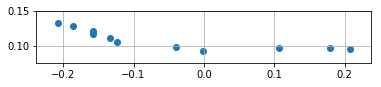

In [139]:
%matplotlib inline
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(X_row[0])[:, 0], np.array(X_row[0])[:, 2])
plt.grid()
plt.show()

In [14]:
np.random.seed(0)
random.seed(0)
X, labels = [], []


row_count = 0
for idx, row in df[train_mask].iterrows():
    
    X_row, labels_row, _ = process_row(row, n_factors=5, jitters=[0, 5, 10])
    X.extend(X_row)
    labels.extend(labels_row)
    
    if row_count % 1000 == 0:
        print('Percentage complete: {}'.format(row_count / df[train_mask].shape[0]))
    row_count += 1
    
X, labels = np.array(X) / 2.0, np.array(labels) / 10000.0


Percentage complete: 0.0
Percentage complete: 0.06574621959237344
Percentage complete: 0.13149243918474687
Percentage complete: 0.19723865877712032
Percentage complete: 0.26298487836949375
Percentage complete: 0.32873109796186717
Percentage complete: 0.39447731755424065
Percentage complete: 0.46022353714661407
Percentage complete: 0.5259697567389875
Percentage complete: 0.591715976331361
Percentage complete: 0.6574621959237343
Percentage complete: 0.7232084155161078
Percentage complete: 0.7889546351084813
Percentage complete: 0.8547008547008547
Percentage complete: 0.9204470742932281
Percentage complete: 0.9861932938856016


In [16]:
class KeypointsDataset(Dataset):
    """Keypoints dataset."""

    def __init__(self, X, labels, transform=None):
        self.X = X
        self.labels = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.labels[idx]

        return torch.from_numpy(x).float(), torch.from_numpy(np.array([y])).float()


In [17]:
# TODO: Define your network architecture here
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(33, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
        



In [18]:
from torch.utils.data import DataLoader

dataset = KeypointsDataset(X, labels)
dataloader = DataLoader(dataset, batch_size=25, shuffle=True, num_workers=1)


In [19]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
network = Network()
# network = network.to(device)
epochs = 2000
optimizer = torch.optim.Adam(network.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()

for epoch in range(epochs):
    running_loss = 0.0
    for i, data_batch in enumerate(dataloader):
        optimizer.zero_grad()
        X_batch, y_batch = data_batch
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)
        y_pred = network(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 0 and i > 0:
            print(running_loss / i)
    
    loss_for_epoch = running_loss / len(dataloader)
    
    # print validation loss
    preds = network(torch.from_numpy(X_t).float())
    predictions = preds.detach().numpy().squeeze()
    weights = labels_t
    accuracy_1 = np.mean(abs((predictions - weights) / weights))
    accuracy_2 = (np.mean(predictions) - np.mean(weights)) / np.mean(weights)
    
    print('Loss for epoch {}: {}'.format(epoch, loss_for_epoch))
    print('Validation accuracy (per-fish): {}'.format(accuracy_1))
    print('Validation accuracy (per-fish): {}'.format(accuracy_2))





0.1998332178965211
0.11841573372483254
0.0883408804051578
0.07265973487403243
0.0627638279683888
0.055786761455237865
0.050870586246518155
0.04694808329339139
0.04362599842871229
0.040816173049621284
0.03834664713718336
0.03610864637962853
0.03410851811990142
0.03230875896672452
0.030718571346563597
0.029314924091449937
0.028008503879365675
0.026804528777203004
0.02573690201793062
0.024757121585775168
0.02387092094485914
0.02304674386120909
0.02228472114864575
0.021556635815553213
0.02088892205604352
0.020276512858825018
0.019692763355905536
0.019161511750218258
0.01864300197419903
0.018166322565753946
0.01771647563200414
0.017283278058130236
0.016868215915500046
0.016480763214160962
0.01614161938671688
0.015793869931108526
0.015458157774488869
0.015146826275281217
0.014833886148020003
0.01454478007646685
0.0142599882275752
0.013995088639619228
0.013736484409228703
0.013487483641841788
0.013253247592041993
0.01302092276492065
0.012803830748369441
0.012607945156778442
0.0124281127315504

0.001395488299199723
0.0013948140447055698
0.001394119593235609
0.0013929674692575217
0.0013931559112038033
0.00139254394174502
0.001391145999853249
0.0013902708593068174
0.0013892582074140332
0.001388651418224485
0.0013881446277978567
0.0013868133761014874
0.0013862478401116486
0.0013849076167389285
0.001384922596466797
0.0013852154320744916
0.0013848488378342334
0.001383878584668349
0.001383609477971756
0.0013828555991893799
0.001382201499793427
0.0013815237320492048
0.0013814517463712642
0.00138114126460737
0.0013800395310399882
0.0013792359318904345
0.0013785228187986167
0.0013779514886141208
0.0013773323877875766
0.0013765556297199064
0.0013765262571006284
0.001375907508127516
0.0013748893865583648
0.0013748041630111403
0.0013735992603877963
0.0013726279878525506
0.0013717205741650912
0.0013713731170234193
0.0013714794675072815
0.0013708965731680154
0.0013700231162880115
0.0013709403600058487
0.0013702111969755976
0.0013689750912197355
0.0013687957551052254
0.0013678245277243956
L

0.0010916375664672619
0.0010914212140980654
0.0010910658712710848
0.0010914535622194473
0.0010903978665914651
0.0010897211154367271
0.0010896757793078607
0.001089015364846809
0.0010892937959275594
0.0010884094475916534
0.0010880345534884002
0.001087505844535387
0.0010869348723259891
0.0010863439935189186
0.001086462821068448
0.00108676984352866
0.0010863519258164456
0.001086383487740785
0.001086038735237671
0.0010860292697757287
0.0010865796955797811
0.0010853968185472241
0.0010860391013884228
0.0010858521805303797
0.0010855110562866365
0.001085269141729055
0.0010854611941449137
0.0010861193629274051
0.001085686927080301
0.0010855565698757882
0.0010857223189743082
0.0010856615670353927
0.0010850077217728277
0.001084516048806628
0.001084574285347852
0.0010842428251829992
0.001083711408227446
0.0010835733648420702
0.00108328214758136
0.0010830092186888453
0.0010835790143537947
0.0010830041594778557
0.001082319913943956
0.0010814746691525216
0.0010813719441677483
0.0010810410511007114
0.0

0.0009841790036799912
0.0009845301052852544
0.000986501102954059
0.000987131395927281
0.0009890856142195773
0.0009875871374662472
0.0009871507023284343
0.000985990835074012
0.0009838387245624538
0.0009843924969261154
0.0009839483511837387
0.0009829910615321595
0.0009818816159026088
0.0009826344681132468
0.0009810716331937373
0.000979836068530154
0.000980225591024103
0.0009793125347323439
0.0009794222467417756
0.0009798419312309389
0.0009799623075931736
0.0009792207692910725
0.0009791570080046042
0.0009783809306432626
0.000977775331748105
0.0009769950362331454
0.000976447303741947
0.0009765903400910099
0.0009767484229019222
0.0009761718238089662
0.0009769627318774992
0.0009770191996918024
0.0009772862481318791
0.0009773862137262767
0.0009759612272049438
0.0009748894904659232
0.0009758353715110991
0.0009756769362190555
0.0009758124922604218
0.0009754516545268247
0.0009752195142728046
0.000974390097857064
0.000974708619644261
0.0009750027003643077
0.0009753548757414267
0.00097442946176433

0.0009155225737359776
0.0009156144542016923
0.0009153951081111479
0.0009152378356766832
0.000915224305913398
0.0009150798520289554
0.000915511911025706
0.0009154859337982886
0.0009150170856381285
Loss for epoch 6: 0.0009149396408617042
Validation accuracy (per-fish): 0.11180715688566593
Validation accuracy (per-fish): -0.030144001716452325
0.0008684020943474025
0.0008935652470972855
0.0009174705451005139
0.0009254135698574827
0.0009228475934942253
0.0009157465377938933
0.0009080086472386029
0.0009075170845426328
0.0009092572078063515
0.0009036253047961509
0.0009155224843760317
0.0009115350402256202
0.0009068001291038505
0.0009028785296894576
0.0008949340124187681
0.0008985643871528737
0.000895619447949096
0.0008973314711895203
0.0008997174685416547
0.0008949873584206216
0.0008922135710045473
0.0008917904578662605
0.0008887695743317676
0.0008878943310264731
0.0008881701930076815
0.0008863479811631036
0.0008939731165689106
0.0008949855176095818
0.0008966268870903275
0.0008964652298212362

0.0008508107834960027
0.000850571606396968
0.000850742248688227
0.0008506320833405173
0.0008506256920799356
0.0008506398999701535
0.000850656285696286
0.0008506112508345993
0.0008510558591196907
0.0008513857790734619
0.0008510546659278246
0.0008510999008295154
0.0008508591553730071
0.0008507056026286733
0.0008511022178563214
0.0008513775110110053
0.0008508936882039063
0.0008511123012458828
0.0008511626194637568
0.0008511951642112763
0.000851052866642897
0.0008511704940862313
0.0008509821657984492
0.0008502357927402666
0.0008502849369710241
0.0008506086689280837
0.0008506375317704727
0.0008510262587324611
0.000850936925415323
0.0008509630269031999
0.0008511802033223048
0.0008508937102060584
0.000850822383454951
0.0008505505146754801
0.0008505056607162779
0.0008504087669883698
0.0008501084147329971
0.0008497870131632839
0.0008496177667635168
0.0008494652915695851
0.0008497627379794963
0.0008499512047489918
0.0008496492313638729
0.0008498038261717264
0.0008501710026340899
0.00084971890960

0.0008058470521561354
0.000806063905460178
0.0008061722353500325
0.0008054921684982596
0.0008064843752948814
0.0008060816020363182
0.0008058550998222713
0.0008056650990396901
0.0008057043029128536
0.0008059298043587082
0.0008056134652536692
0.0008052126720706131
0.0008050081646405698
0.0008048998766294655
0.0008045380817593566
0.0008037301307040059
0.0008032628954357566
0.0008042177431222323
0.0008034561125119937
0.0008031413394809886
0.0008030488519389018
0.000802591455153015
0.0008030539872467698
0.0008029566612879303
0.0008026676567441454
0.0008024713636628943
0.0008021830775763928
0.0008021922485369152
0.0008028215859123401
0.0008023962819020704
0.0008020988072443822
0.0008018585279139436
0.0008021486751359745
0.0008015284883523626
0.0008013205156420498
0.0008013775795590941
0.0008016928942752598
0.0008010473678085214
0.0008009610007194659
0.0008005680746578422
0.0008002097422610225
0.0008002014605238704
0.0008004816336408623
0.0008004992559874721
0.0008003920467692992
0.0008000940

0.0007654421719962556
0.0007718488551258548
0.0007727383557196137
0.000774093762202507
0.0007731386233645025
0.0007713092293193941
0.0007680729278482348
0.0007688211746141821
0.0007666523921701203
0.0007674376930866856
0.0007645588329390963
0.0007647684092808049
0.0007651818708161174
0.0007646009355938014
0.0007638479241528936
0.0007651037562707995
0.0007662086846312377
0.0007660784280619048
0.0007664488719242131
0.0007650882293985758
0.0007647585440039014
0.000764979640548149
0.0007643547935731476
0.0007643567231291224
0.0007640591878844134
0.0007642027136455176
0.0007636539377216693
0.0007629863905441557
0.000764445659012629
0.0007640225478680805
0.0007667340254651525
0.0007675771644627526
0.0007671757444798762
0.0007654078330812567
0.0007663005576730938
0.0007650813098463878
0.0007653680174917099
0.0007663880298402873
0.0007664633984758337
0.0007654573224267965
0.0007665602847373521
0.0007664757020661216
0.000766713799399942
0.0007662991693458456
0.0007660341990170613
0.000765848797

0.0007423515125112825
0.0007424204366522535
0.0007428693773954887
0.000743016892417966
0.0007428454507804748
0.0007427762730774209
0.000742658625092466
0.0007424221209259496
0.0007425535746183919
0.0007425933034392074
0.000742623694213862
0.0007423311495858301
0.0007424827072432179
0.0007424126390400784
0.0007425006282370618
0.0007424418880672064
0.000742641436683814
0.0007426966981707935
0.0007425104001503267
0.0007425842707789581
0.0007425334199372931
0.0007425969493197798
0.0007425406438219914
0.0007422807691335224
0.0007426686208344442
0.0007425686841123551
0.0007425240520082886
0.0007426788916799793
0.0007425624289804546
0.0007426543725547045
0.0007426580424859398
0.0007427061725933428
0.0007429986798617356
0.0007431715783008612
0.0007431158276442359
0.0007429968020912476
0.0007428058546023609
0.0007433222914972391
0.0007431387370708676
0.0007431901875607199
0.0007431840837225022
Loss for epoch 13: 0.0007430950510225583
Validation accuracy (per-fish): 0.08431697595876185
Validatio

0.000717077782039035
0.0007166750353472625
0.000716413640810978
0.0007164376309421121
0.0007163825527475364
0.0007163386958066104
0.0007162511843666636
0.0007160399434147182
0.0007164792821824185
0.0007161717603754615
0.0007157543717204601
0.0007159221078012099
0.0007157311549752735
0.0007155829352113422
0.0007157097550639523
0.0007162567622928632
0.0007160410288767889
0.0007156069631968247
0.0007154079320736039
0.0007157396659420102
0.000715778577370459
0.0007163055058347079
0.0007159680486618957
0.0007158981231843813
0.000715376148733426
0.0007149335855241072
0.0007146809273485647
0.0007143607477636953
0.0007141095976261116
0.0007141323603771499
0.0007138733866539945
0.0007140166907068175
0.0007140377685155205
0.0007146700269388507
0.0007149587663908577
0.0007153564309949919
0.0007152934286628994
0.0007157652539211846
0.0007161513021361118
0.0007165259505888349
0.0007165874057106015
0.0007165616793509495
0.0007163801658220145
0.0007158595521430375
0.0007160550057777702
0.000715837136

0.0006979222460173101
0.0006983452953924522
0.000698269027631554
0.0006968233983323444
0.0006961844193374775
0.0006952481687543555
0.0006947459788599825
0.0006944380181327385
0.0006944615498650819
0.0006947776210654411
0.0006945246427775394
0.000693571042040652
0.0006941518898420944
0.0006952654856431763
0.0006937188347400792
0.0006941593155985878
0.0006949106105122834
0.0006945229101029326
0.0006932620516051359
0.0006934946062943764
0.0006938790138280923
0.0006933900235890178
0.0006950814199281276
0.00069635515932792
0.000696913181938572
0.0006969885942493824
0.0006970192535424746
0.0006968294423053079
0.0006964826137176715
0.000696207933107967
0.0006960557865839929
0.0006965472298683241
0.0006960096494114186
0.0006960420186060219
0.0006956259798661685
0.0006958078083343713
0.0006954942582103604
0.0006959708338642182
0.000695412556096391
0.0006961575996615994
0.0006955271082326112
0.0006956345437455721
0.000695720053390074
0.0006953831858861829
0.0006949634167188548
0.0006946258341422

0.0006749979437211318
0.0006752336710150546
0.0006752113661772879
0.0006751619788364211
0.0006751090437655176
0.0006750448006157915
0.0006750525559223856
0.0006751344407216472
0.0006752050096358014
Loss for epoch 18: 0.0006751742632395488
Validation accuracy (per-fish): 0.09466047380090739
Validation accuracy (per-fish): -0.06170194022622604
0.0006251554566551931
0.0006547464096365729
0.0006618819023424294
0.0006688379817569512
0.000678539600718068
0.0006701155206974363
0.0006717056101271218
0.0006832906184718013
0.0006846046700957232
0.0006825482180283871
0.0006834932713801126
0.0006890502447276959
0.0006857002306563888
0.0006851103458133626
0.000686931689842216
0.0006891373019516322
0.0006869370884327081
0.0006824003632128653
0.0006802814448249256
0.0006791501193656586
0.0006816048804362903
0.0006776345155098665
0.0006775088469325768
0.0006784089745148473
0.0006769923367188312
0.0006783456403018835
0.0006764474294808072
0.0006770797859020864
0.0006746531031114563
0.000674244630378477

0.000653389524890346
0.000654126950235288
0.0006545180725454763
0.0006550652390372609
0.0006553676490519388
0.0006553678075918108
0.000655253481256085
0.000655259580467041
0.0006548036678001557
0.0006547258128877729
0.0006547324961692785
0.0006548339044686719
0.0006543449840274049
0.0006543874431825953
0.0006542816610374082
0.0006538246527046655
0.0006536217988895068
0.000654212395395145
0.0006536765305494521
0.0006537456813020981
0.0006536887654510792
0.000653559426381109
0.0006530675705235903
0.0006528485544185969
0.0006529333722882615
0.0006529144878482204
0.0006527611478982099
0.0006527176917296899
0.0006521525790388097
0.0006521132192356163
0.0006519318004273224
0.0006517264395480134
0.0006517718019733755
0.0006521432109127937
0.0006520838521404325
0.0006518324678571926
0.000651886004696095
0.0006515758194937109
0.0006516945890203644
0.0006515122298927356
0.0006515685865978417
0.0006512364708560398
0.0006513291402641033
0.0006514288458809302
0.000651128150733515
0.0006512335320244

0.0006315968195607032
0.0006320443351939468
0.0006325093822906638
0.00063209464036598
0.0006322050507346497
0.000631960903722877
0.0006334573506024927
0.0006335722216086544
0.0006336227015420919
0.000634285873059724
0.0006351405704448222
0.0006362919766227637
0.0006360916457843915
0.0006356300574239307
0.0006354330153091882
0.0006360555176484845
0.0006365404898663636
0.000636585348088135
0.0006360788242318449
0.0006358862737074888
0.0006356462158918457
0.0006360294658857082
0.000636095012781152
0.0006358257764984974
0.0006361726680944569
0.0006361181079395889
0.0006364119376289286
0.0006360827438350368
0.0006355795322630207
0.0006355741476339819
0.0006354966506626591
0.0006356531843410083
0.0006356609508736503
0.0006353902225217442
0.0006349612577586023
0.0006347770063748451
0.000634941038332998
0.000635311236317806
0.0006351999206137783
0.0006351248503418372
0.0006348327875309485
0.000634838058953193
0.0006348130380174553
0.0006348476115859995
0.000635201888434211
0.000634957707493672

0.0006240115333002905
0.0006208778607833665
0.0006204457461879226
0.0006169569201148605
0.0006193544401903637
0.0006229701462074272
0.0006208794212249235
0.0006199972539236668
0.0006175583817882095
0.0006182231963495723
0.0006167744866476054
0.0006149697369363383
0.0006169094314931758
0.0006152311482583172
0.0006160994951981896
0.0006175301972055628
0.0006173795877066368
0.0006164939081733764
0.0006172700215435779
0.0006169953565570592
0.0006154584635401584
0.000616123007490092
0.0006161043030174609
0.0006175727385524601
0.0006178809722150617
0.0006178712110757748
0.0006164673570310697
0.000615706843561574
0.0006159359150809575
0.0006161514335641792
0.0006159407090561454
0.0006148623865459391
0.0006158612365925365
0.0006167538065287493
0.0006159679712465731
0.0006153589180230126
0.0006148500006943672
0.0006151511601692962
0.0006153790093311626
0.0006158663183080287
0.0006154001785658433
0.0006151353186093426
0.000614239924064444
0.0006138533832119596
0.0006135520317281285
0.00061264073

0.0006089841085680704
0.0006089985513135406
0.0006087137206729191
0.0006090111283876468
0.0006086507276805523
0.0006085356980692766
0.0006086082578430036
0.0006085691717762225
0.0006084908383361633
0.0006086144951163812
0.0006085189096987821
0.0006083717758295284
0.0006084716916041582
0.0006083765778607198
0.0006081583468587405
0.0006080827247987957
0.0006080460452451123
0.000608205606019255
0.0006077883583072291
0.0006077522550696137
0.0006075763227871297
0.0006073316905448162
0.0006075039819597336
0.0006075286511152696
0.0006076270703748118
0.0006075900665040868
0.000607411133318274
0.0006075440827356687
0.0006075396698841359
0.0006074432267611082
0.0006069809614895672
0.0006068161762845095
0.0006070533916628098
0.0006069523540315525
0.0006069380362515024
0.0006070251716047768
0.0006069549662676693
0.0006069501127044249
0.0006070125654867817
0.0006074831021048396
0.0006077385402070677
Loss for epoch 25: 0.0006077858239086773
Validation accuracy (per-fish): 0.10039950486695953
Validat

0.0005931537893305755
0.0005931101590734519
0.0005931066503301606
0.0005935309205439397
0.0005942554673157774
0.0005948260144726627
0.000594767548034348
0.0005946650306011887
0.0005944653457013142
0.0005946162182030888
0.0005945280216492392
0.0005950391834715048
0.0005952560223015665
0.0005947438282926417
0.0005945270691195366
0.0005945681929838611
0.0005942336420302458
0.0005945019658700073
0.0005940062506948607
0.0005937947073592416
0.0005938633525337747
0.0005937874277440239
0.0005942487710826478
0.0005942420586310126
0.0005946323810452152
0.0005943480499969424
0.0005945788418418542
0.0005941240479482421
0.0005944461078742398
0.0005944702186357488
0.0005946004270850348
0.0005947374991068604
0.0005947407579863555
0.0005944579986955521
0.0005945973355483147
0.0005945005036653662
0.000594894713645423
0.000594915821680088
0.0005949928074993737
0.0005949487687430763
0.0005945532707866126
0.0005944728561291943
0.0005946034482315698
0.0005949576639730462
0.0005951043406169553
0.00059492676

0.0005741023357961936
0.0005740613073506514
0.0005741834755953073
0.0005733900593346334
0.0005730663549283967
0.0005725315685748892
0.0005723587761881304
0.0005722586145000403
0.0005724376641393808
0.0005720509983776927
0.0005720400303656342
0.0005714870477571947
0.0005715500626153652
0.0005718014434169163
0.0005716874508295002
0.0005717823897547562
0.0005704807282168148
0.0005707955352715999
0.0005717170091576498
0.0005722274087946227
0.0005728391781010589
0.0005723438105119653
0.0005725437184889375
0.0005729346667940262
0.0005741069491372221
0.0005741703350819686
0.0005740793981036802
0.0005740920001699124
0.0005744210003176705
0.0005740484254132944
0.0005736537232115114
0.000573429378793942
0.0005732723040162892
0.0005728384197518608
0.0005726137049808771
0.0005723571697467932
0.0005721543385371628
0.0005716828165203056
0.0005718220464357942
0.0005719466578874596
0.0005718823054644156
0.0005717272990858129
0.0005719370314059386
0.0005730664372644646
0.0005733473635784601
0.000574054

0.0005721464167568968
0.0005722609995705973
0.0005721249141220696
0.0005719524611339191
0.0005718929616315121
0.0005717014590426026
0.0005714267893467637
0.000571198745422797
0.0005710356706773788
0.0005709635493045459
Loss for epoch 30: 0.0005709706600156362
Validation accuracy (per-fish): 0.09957318065646198
Validation accuracy (per-fish): -0.04909750408431909
0.0005646446847822517
0.000540579684311524
0.0005446534658646367
0.0005548519428339205
0.0005706114023341797
0.00057309537580295
0.0005776591507102629
0.0005753047354301089
0.0005724268849007785
0.000576208718601265
0.0005740871495667802
0.0005769232942717887
0.0005789242128622181
0.0005814800930446446
0.0005782161564178144
0.0005757806717338099
0.0005763021803902709
0.0005740750564533906
0.0005715998062346204
0.0005704154924897012
0.0005692267549637195
0.0005700122202622217
0.0005714418782989251
0.0005716697696152551
0.0005711679520783946
0.000569987692137007
0.0005702374148973764
0.0005692395622359722
0.000567759155930052
0.0

KeyboardInterrupt: 

In [395]:
loss_for_epoch

0.0006128171371036422

In [107]:
body_parts

['ADIPOSE_FIN',
 'ANAL_FIN',
 'DORSAL_FIN',
 'EYE',
 'HYPURAL_PLATE',
 'LOWER_PRECAUDAL_PIT',
 'PECTORAL_FIN',
 'PELVIC_FIN',
 'TAIL_NOTCH',
 'UPPER_LIP',
 'UPPER_PRECAUDAL_PIT']

In [249]:
X_t[idx]

array([[-0.05409   , -0.13786634,  0.09531684],
       [ 0.02924214, -0.11078325,  0.09547757],
       [-0.06688203,  0.07498619,  0.09917452],
       [ 0.00864582,  0.28542094,  0.10142483],
       [-0.03665106, -0.25312787,  0.09194137],
       [-0.00924977, -0.20650233,  0.093388  ],
       [ 0.06206984,  0.22063332,  0.1030322 ],
       [ 0.06666523,  0.01060644,  0.09885304],
       [-0.04112755, -0.28577788,  0.090334  ],
       [ 0.002321  ,  0.30204993,  0.09547757],
       [-0.04970892, -0.20636638,  0.09274505]])

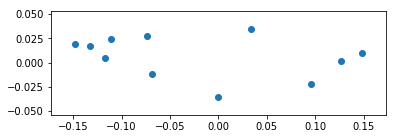

In [305]:
print('Prediction: {}'.format(predictions[idx] * 1e4))
print('Ground Truth: {}'.format(labels_t[idx] * 1e4))

Prediction: 2999.4410276412964
Ground Truth: 2605.0


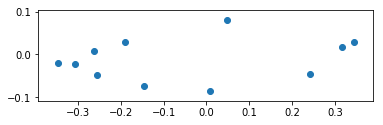

In [136]:
idx = 9
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(X[idx][:, 0], X[idx][:, 1])

In [303]:
u = torch.from_numpy(X[idx]).float()
pred = network(u.view(1, *u.shape)).item() * 1e4
print('Prediction: {}'.format(pred))
print('Ground Truth: {}'.format(labels[idx] * 1e4))

Prediction: 6608.65843296051
Ground Truth: 6865.0


In [273]:
X[idx]

array([[-0.01438313, -0.04800292,  0.02214788],
       [ 0.0210271 , -0.03767746,  0.03215258],
       [-0.02537067,  0.01831417,  0.02396226],
       [ 0.00453629,  0.09625329,  0.0297017 ],
       [-0.00790916, -0.08347626,  0.0219872 ],
       [ 0.00797183, -0.06772529,  0.02792235],
       [ 0.02278395,  0.07059543,  0.03421356],
       [ 0.0263703 ,  0.00338867,  0.0287346 ],
       [-0.00756408, -0.09391571,  0.02190838],
       [-0.00179136,  0.10658341,  0.02324335],
       [-0.00880064, -0.068762  ,  0.01978692]])

In [130]:
list(np.where(0.05 / X[:, :, 2].mean(axis=1) > 2)[0])

[61,
 68,
 69,
 149,
 153,
 284,
 366,
 369,
 370,
 550,
 611,
 675,
 676,
 677,
 735,
 736,
 846,
 892,
 893,
 1065,
 1068,
 1069,
 1253,
 1254,
 1257,
 1258,
 1376,
 1378,
 1551,
 1552,
 1684,
 1741,
 1824,
 1880,
 2106,
 2231,
 2232,
 3512,
 3623,
 3714,
 3891,
 3904,
 4240,
 4344,
 4590,
 4591,
 4702,
 4827,
 5055,
 5058,
 5059,
 5060,
 5214,
 5891,
 5947,
 5948,
 6191,
 6787,
 6803,
 6810,
 6856,
 6859,
 6875,
 8048,
 8059,
 8063,
 8096,
 8119,
 8182,
 8598,
 8599,
 8600,
 8635,
 8636,
 8637,
 8866,
 9200,
 9791,
 9794,
 9796,
 9828,
 9829,
 9831,
 9832,
 9856,
 9858,
 9859,
 9861,
 10199,
 10200,
 10201,
 10202,
 10203,
 10204,
 10205,
 10248,
 10249,
 10250,
 10251,
 10253,
 10261,
 10283,
 10284,
 10285,
 10286,
 10287,
 10288,
 10289,
 10291,
 10294,
 10295,
 10296,
 10303,
 10388,
 10389,
 10390,
 10391,
 10392,
 10394,
 10395,
 10396,
 10397,
 10398,
 10399,
 10400,
 10401,
 10402,
 10403,
 10404,
 10405,
 10406,
 10407,
 10408,
 10423,
 10424,
 10425,
 10426,
 10427,
 10428

In [125]:
np.where(0.05 / X_t[:, :, 2].mean(axis=1) > 2)

(array([ 11,  12,  13,  15,  20,  23,  24,  27,  31,  36,  37,  38,  40,
         42,  51,  53,  55,  59,  60,  61,  62,  69,  72,  75,  79,  84,
         90,  92,  97, 107, 110, 112, 115, 116, 117, 124, 133, 140, 161,
        167, 172, 175, 176, 184, 190, 193, 200, 209, 216, 217, 221, 224,
        234, 237, 238, 242, 245, 246, 247, 249, 250, 252, 254, 255, 256,
        262, 263, 272, 276, 277, 281, 285, 287, 288, 292, 293, 296, 297,
        298, 304, 305, 307, 312, 329, 332, 333, 342, 344, 349, 351, 354,
        358, 359, 360, 361, 363, 365, 387, 389, 397, 400, 401, 403, 404,
        408, 412, 414, 415, 416]),)

In [ ]:
loss_for_epoch

In [ ]:
torch.cuda.is_available()

In [205]:
df.iloc[1833]

left_url                   http://aquabyte-axiom-rectified.s3.eu-west-1.a...
fish_id                          190906-392e1f04-7eb4-4bb7-8a95-ae0a364c8fbb
weight                                                                   967
data                       {'species': 'salmon', 'location': 'IMR Austevo...
stereo_parameters_url      http://aquabyte-stereo-parameters.s3.eu-west-1...
ts_created                                  2019-10-25 00:15:16.068707+00:00
ts_updated                                  2019-10-25 00:16:27.929018+00:00
data_collection_type_id                                                 None
id                                                                    725645
fish_detection_id                                                       None
annotated_by_email                                      bati5@cogitotech.com
is_qa                                                                  False
is_skipped                                                             False

In [25]:
kpids, X_t, labels_t, est_weights = [], [], [], []
body_parts = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])

for idx, row in df[~train_mask].iterrows():
    X_row, labels_row, est_weight = process_row(row, n_factors=1, jitters=[0], network=network)
#     X_row, labels_row, est_weight = process_row(row, n_factors=1, jitters=[0])
    X_t.extend(X_row)
    labels_t.extend(labels_row)
    kpids.append(row.id)
    if len(est_weight) > 0:
        est_weights.extend(est_weight)
    else:
        est_weights.append(None)
    
    
X_t, labels_t = np.array(X_t) / 2.0, np.array(labels_t) / 10000.0
tdf = df[~train_mask].copy(deep=True)
tdf['prediction'] = est_weights
tdf['prediction'] = tdf['prediction'] * 1e4
tdf['depth'] = tdf.world_keypoints.apply(lambda x: np.mean([wkp[1] for wkp in x.values()]) if x else None)


In [218]:
tdf['error'] = tdf.prediction - tdf.weight

In [26]:
# preds = network(torch.from_numpy(X_t).float())
# predictions = preds.detach().numpy().squeeze()
# weights = labels_t

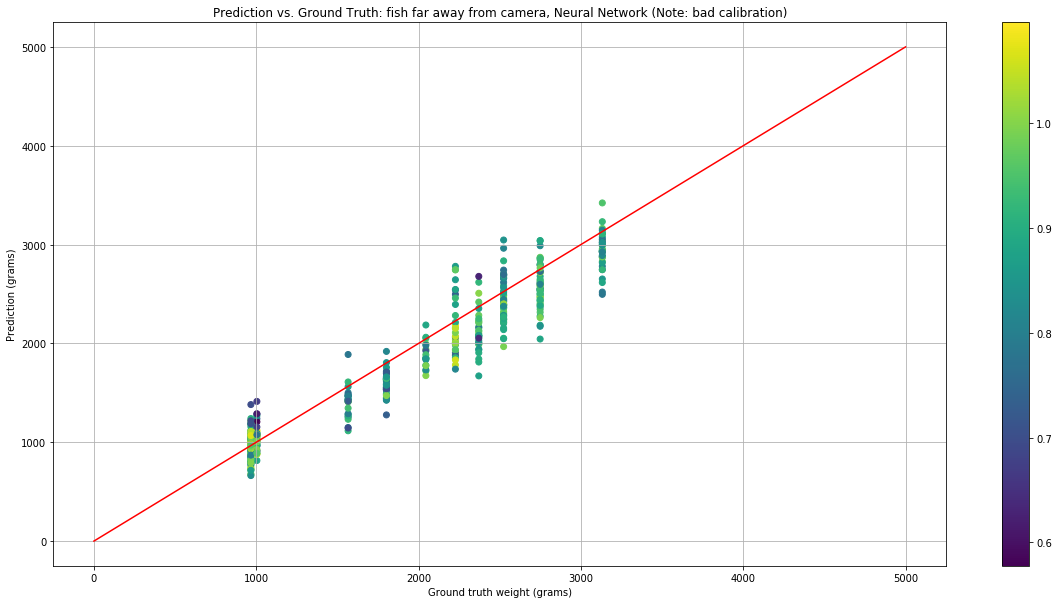

In [27]:
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(tdf.weight, tdf.prediction, c=tdf.depth)
plt.colorbar(sc)
plt.plot([0, 5e3], [0, 5e3], color='red')
plt.title('Prediction vs. Ground Truth: fish far away from camera, Neural Network (Note: bad calibration)')
plt.xlabel('Ground truth weight (grams)')
plt.ylabel('Prediction (grams)')
plt.grid()
plt.show()

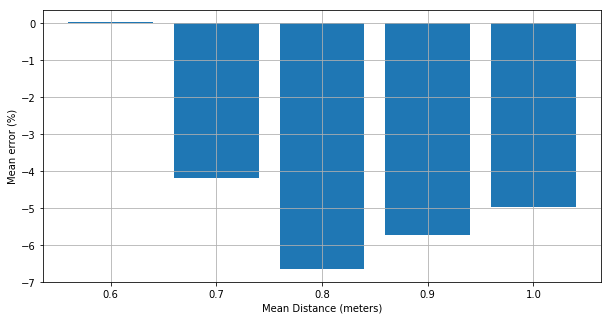

In [28]:
depths = [round(x, 1) for x in list(np.arange(0.6, 1.2, 0.1))]
error_pcts = []
for idx in range(len(depths)-1):
    mask = (tdf.depth > depths[idx]) & (tdf.depth < depths[idx+1])
    mean_prediction = tdf[mask].prediction.mean()
    mean_ground_truth = tdf[mask].weight.mean()
    error_pct = (mean_prediction - mean_ground_truth) / mean_ground_truth
    error_pcts.append(error_pct)
    

plt.figure(figsize=(10, 5))
ind = list(range(len(depths[:-1])))
plt.bar(ind, np.array(error_pcts) * 1e2)
plt.xticks(ind, depths[:-1])
plt.xlabel('Mean Distance (meters)')
plt.ylabel('Mean error (%)')
plt.grid()
plt.show()

In [29]:
np.mean(abs((tdf.prediction - tdf.weight)/tdf.weight).values)

0.10127210744566567

In [31]:
(tdf.prediction.mean() - tdf.weight.mean()) / tdf.weight.mean()

-0.05554897566282612

In [220]:
tdf[tdf.error < -500]

,left_url,fish_id,weight,data,stereo_parameters_url,ts_created,ts_updated,data_collection_type_id,id,fish_detection_id,...,left_image_url,right_image_url,left_crop_metadata,right_crop_metadata,camera_metadata,captured_at,world_keypoints,prediction,depth,error
3884,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-72e76143-a9a4-4c8a-acb1-7b16f51fab2f,2749,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 00:35:31.455296+00:00,2019-10-30 00:38:17.481360+00:00,None,726962,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'baseline': 0.10171471260453811, 'focalLength...",2019-09-06 12:21:36.660000+00:00,"{'UPPER_LIP': [0.2093764188047127, 0.682908799...",2183.966339,0.879094,-565.033661
7929,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-8da0aa1c-c074-481c-961e-1a6673d52501,2371,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 01:00:32.647825+00:00,2019-10-30 16:27:17.148726+00:00,None,726800,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'baseline': 0.10171471260453811, 'focalLength...",2019-09-06 11:18:52.869000+00:00,"{'UPPER_LIP': [0.2912106490531851, 1.059747074...",1811.578274,0.899974,-559.421726
7931,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-41a69c20-ca06-474f-83b8-f6271383aac8,3132,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 00:24:15.218580+00:00,2019-10-30 00:27:28.951172+00:00,None,726835,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'baseline': 0.10171471260453811, 'focalLength...",2019-09-06 11:56:47.974000+00:00,"{'UPPER_LIP': [-0.0500509620088866, 1.02779490...",2496.461868,0.780491,-635.538132
7951,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-72e76143-a9a4-4c8a-acb1-7b16f51fab2f,2749,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 00:35:39.250797+00:00,2019-10-30 00:36:15.416594+00:00,None,727537,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'baseline': 0.10171471260453811, 'focalLength...",2019-09-06 12:23:45.004000+00:00,"{'UPPER_LIP': [-0.19272125812412924, 0.9647697...",2044.210434,0.883257,-704.789566
9923,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-41a69c20-ca06-474f-83b8-f6271383aac8,3132,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 00:23:22.119278+00:00,2019-10-30 00:26:23.918840+00:00,None,727405,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'width': 4095, 'height': 2999, 'x_coord': 0, ...","{'baseline': 0.10171471260453811, 'focalLength...",2019-09-06 11:58:52.142000+00:00,"{'UPPER_LIP': [-0.3717525234531052, 1.09374965...",2616.068721,0.885677,-515.931279
9924,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,190906-8da0aa1c-c074-481c-961e-1a6673d52501,2371,"{'species': 'salmon', 'location': 'IMR Austevo...",http://aquabyte-stereo-parameters.s3.eu-west-1...,2019-10-30 00:41:31.473635+00:00,2019-10-30 17:53:54.762474+00:00,None,727394,None,...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,http://aquabyte-axiom-rectified.s3.eu-west-1.a...,"{'width': 4

In [34]:
X_t[0].flatten()

array([-0.0571312 , -0.00861963,  0.06661576, -0.04653932, -0.0515407 ,
        0.06979376,  0.03250103,  0.00511255,  0.0759053 ,  0.10607178,
        0.0049958 ,  0.08873952, -0.12136606, -0.00568614,  0.06722691,
       -0.09756472, -0.02762823,  0.0691826 ,  0.06438922, -0.0267791 ,
        0.08739499, -0.00374335, -0.05208515,  0.07492745, -0.13996474,
        0.        ,  0.07016045,  0.13996474,  0.        ,  0.09167306,
       -0.09289264, -0.0043464 ,  0.06686022])

In [96]:
np.corrcoef(X.reshape(X.shape[0], -1)[0], X_t.reshape(X_t.shape[0], -1)[5])

array([[1.        , 0.89290135],
       [0.89290135, 1.        ]])

In [108]:
np.corrcoef(X.reshape(X.shape[0], -1), X.reshape(X.shape[0], -1))

MemoryError: Unable to allocate array with shape (1060500, 1060500) and data type float64

In [105]:
X.reshape(X.shape[0], -1)

array([[-0.24259841,  0.05459641,  0.11432425, ..., -0.33293919,
         0.0294485 ,  0.10752791],
       [-0.24274083,  0.05479126,  0.11385075, ..., -0.33105646,
         0.02788946,  0.11017614],
       [-0.24267046,  0.05397897,  0.11388731, ..., -0.33298591,
         0.02939751,  0.10824429],
       ...,
       [-0.11641525,  0.04046731,  0.05350503, ..., -0.16620801,
         0.02737607,  0.05646831],
       [-0.11361464,  0.04014191,  0.05985792, ..., -0.16240621,
         0.02604009,  0.05853559],
       [-0.11649935,  0.03735316,  0.05191445, ..., -0.16827774,
         0.02685378,  0.04947643]])

In [223]:
ps = []
for i in range(X.shape[0]):
    p = np.corrcoef(X.reshape(X.shape[0], -1)[i], X_t.reshape(X_t.shape[0], -1)[68])[0, 1]
    ps.append(p)


KeyboardInterrupt: 

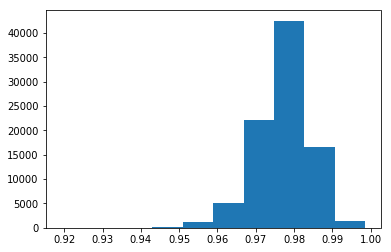

In [224]:
plt.hist(ps)
plt.show()

In [233]:
np.where(np.array(ps) > 0.998)

(array([74620, 74621, 74622, 74623, 74624, 74625, 74626, 74627, 74628,
        74629, 74630, 74631, 74632, 74633, 74634, 74635, 74636, 74637,
        74638, 74639, 74640, 74641, 74642, 74643, 74644, 74647, 74648,
        74649, 74650, 74651, 74652, 74653]),)

In [51]:
np.median(abs((predictions - weights)/weights))

0.12268492754176417

In [52]:
(predictions.mean() - weights.mean())/weights.mean()

-0.02270702152262472

In [680]:
f = '/root/data/alok/biomass_estimation/results/model_lateral_only/results_557ec1732d8bc8bc66951d2ea4e69b935d69b111_model_lateral_only_research-exp-id-03-vikingfjord-20190709-20190710.h5'
tdf = pd.read_hdf(f, 'table')



In [220]:
X_o, est_weights = [], []
body_parts = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])

for idx, row in tdf.iterrows():
    X_row, _, est_weight = process_row(row, n_factors=1, jitters=[0], oos=True, network=network)
    X_o.extend(X_row)
    if len(est_weight) > 0:
        est_weights.extend(est_weight)
    else:
        est_weights.append(None)
    
X_o = np.array(X_o) / 2.0
        

 
 

NameError: name 'tdf' is not defined

In [682]:
tdf['est_weight'] = est_weights

In [683]:
tdf.est_weight.mean()

0.5101224961657422

In [651]:
preds = network(torch.from_numpy(X_o).float())
predictions = preds.detach().numpy().squeeze()

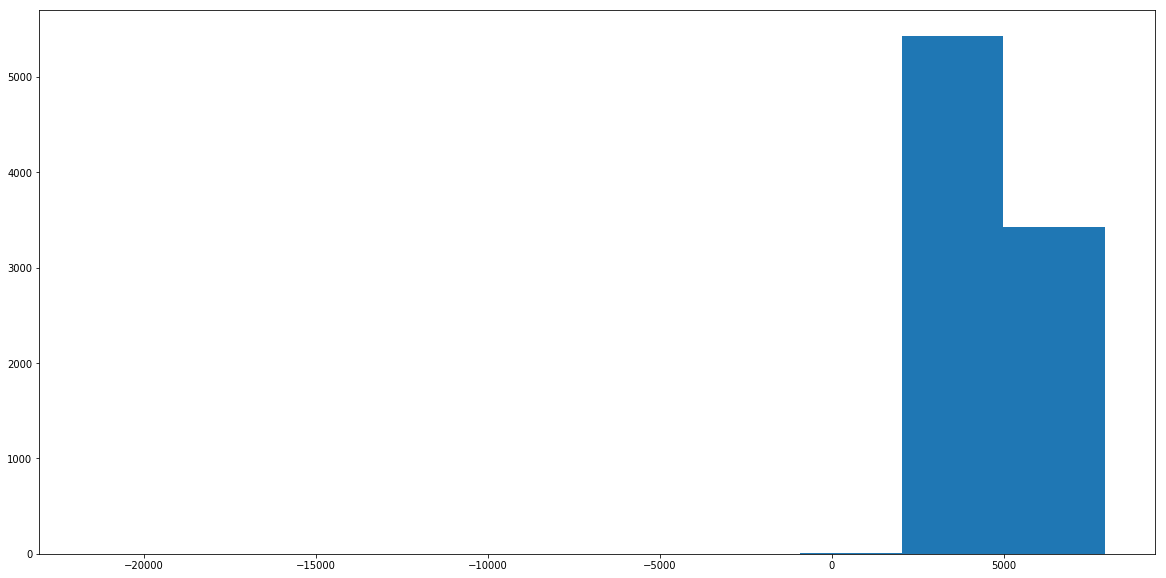

In [623]:
plt.figure(figsize=(20, 10))
plt.hist(predictions * 1e4)
plt.show()

In [574]:
np.mean(predictions * 1e4)

5146.835

In [191]:
s3_access_utils = S3AccessUtils('/root/data')
credentials = json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS']))
rds_access_utils = RDSAccessUtils(credentials)
v = Visualizer(s3_access_utils, rds_access_utils)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index frames_captured_at_date
  "expression-based index %s" % idx_name
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index lati_fish_detections_detected_at_date
  "expression-based index %s" % idx_name


In [222]:
kpids.index(726962)

68

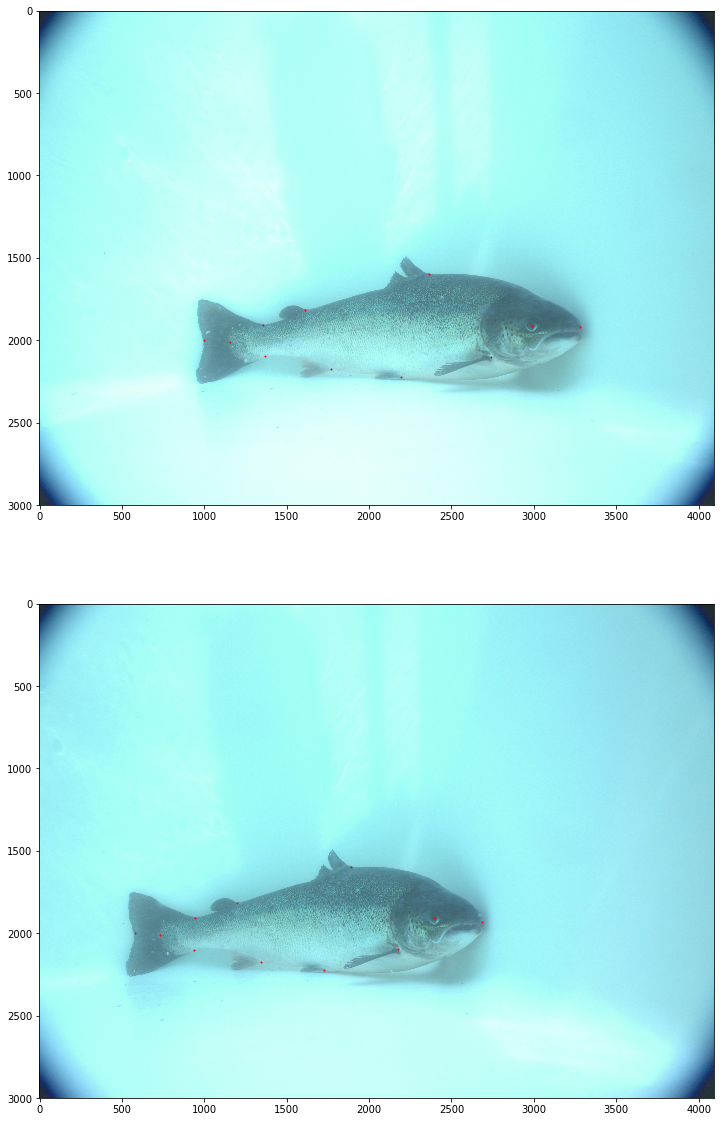

In [221]:
%matplotlib inline
v.load_data(726962)
v.display_crops()

In [614]:
s3_access_utils = S3AccessUtils('/root/data')
credentials = json.load(open(os.environ['PROD_SQL_CREDENTIALS']))
rds_access_utils = RDSAccessUtils(credentials)
v = Visualizer(s3_access_utils, rds_access_utils)


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index lati_fish_detections_lice_annotations_captured_at
  "expression-based index %s" % idx_name
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/sqlalchemy/dialects/postgresql/base.py:3285: SAWarning: Skipped unsupported reflection of expression-based index lati_fish_detections_lice_annotations_reconciled_captured_at
  "expression-based index %s" % idx_name


In [190]:
%matplotlib inline
v.load_data(725633)
v.display_crops()

NameError: name 'v' is not defined

<IPython.core.display.Javascript object>


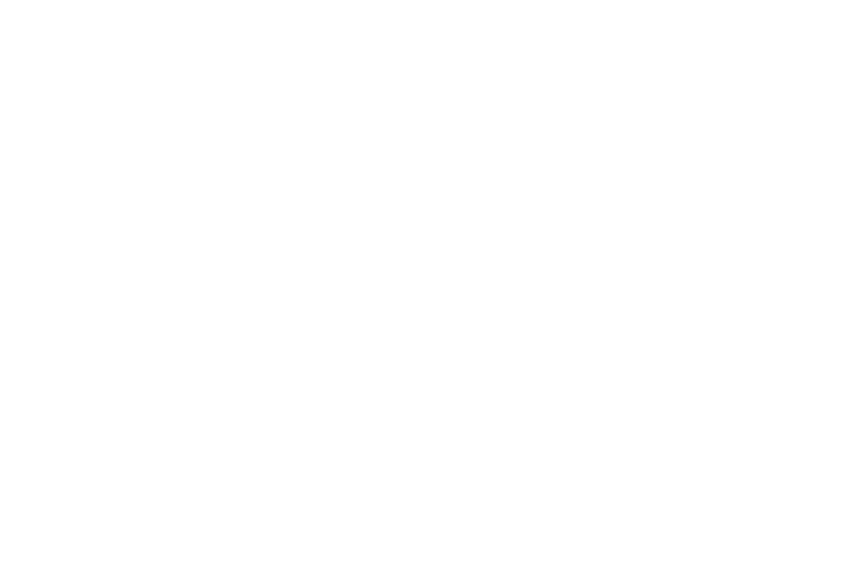

<IPython.core.display.Javascript object>


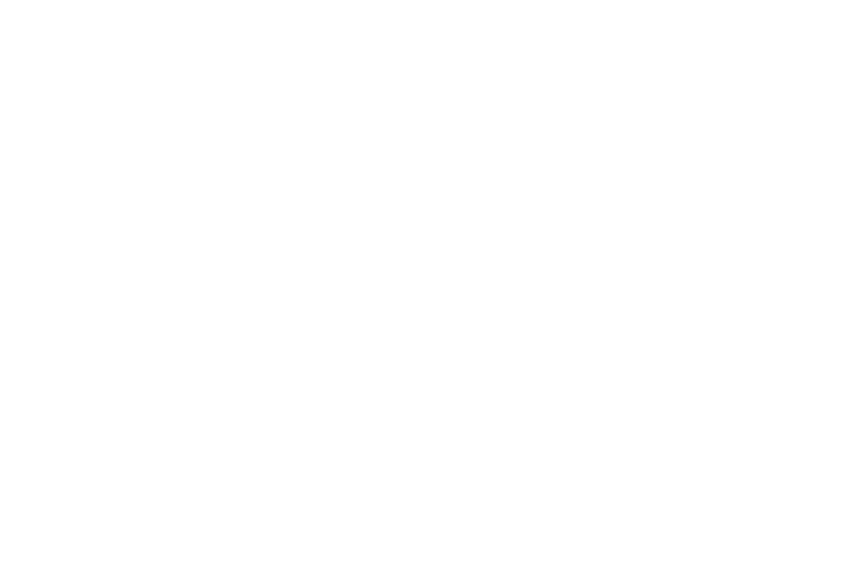

In [489]:
%matplotlib notebook
v.display_3d_keypoints()

In [684]:
def get_fov_cutoffs(fov, cm):
    fov = fov * np.pi / 180.0
    field_size_px = 2*cm['focalLengthPixel'] * np.tan(fov / 2.0)
    min_cutoff = (cm['pixelCountWidth'] - field_size_px) / 2.0
    max_cutoff = (cm['pixelCountWidth'] + field_size_px) / 2.0
    return min_cutoff, max_cutoff

def is_preserved(keypoints, min_cutoff, max_cutoff):
    min_x_left = min([item['xFrame'] for item in keypoints['leftCrop']])
    max_x_left = max([item['xFrame'] for item in keypoints['leftCrop']])
    min_x_right = min([item['xFrame'] for item in keypoints['rightCrop']])
    max_x_right = max([item['xFrame'] for item in keypoints['rightCrop']])
    
    if (min_x_left < min_cutoff) or (min_x_right < min_cutoff) or (max_x_left > max_cutoff) or (max_x_right > max_cutoff):
        return False
    return True
        
    
    
    
    

In [685]:
fovs = list(np.arange(10, 55, 1))
for fov in fovs:
    min_cutoff, max_cutoff = get_fov_cutoffs(fov, tdf.camera_metadata.iloc[0])
    is_preserved_list = []
    for idx, row in tdf.iterrows():
        keypoints = row.keypoints
        if 'leftCrop' in keypoints and 'rightCrop' in keypoints:
            is_preserved_list.append(is_preserved(keypoints, min_cutoff, max_cutoff))
        else:
            is_preserved_list.append(False)

    tdf['is_preserved_{}'.format(fov)] = is_preserved_list



In [695]:
pred_weight_means, sample_sizes = [], []
for fov in fovs:
    mask = tdf['is_preserved_{}'.format(fov)] == True
#     pred_weight_means.append(tdf[mask].est_weight.mean() * 1e4)
    pred_weight_means.append(tdf[mask].estimated_biomass_g.median())
    sample_sizes.append(tdf[mask].shape[0])


<h1> Waiting pen ID #1 </h1>

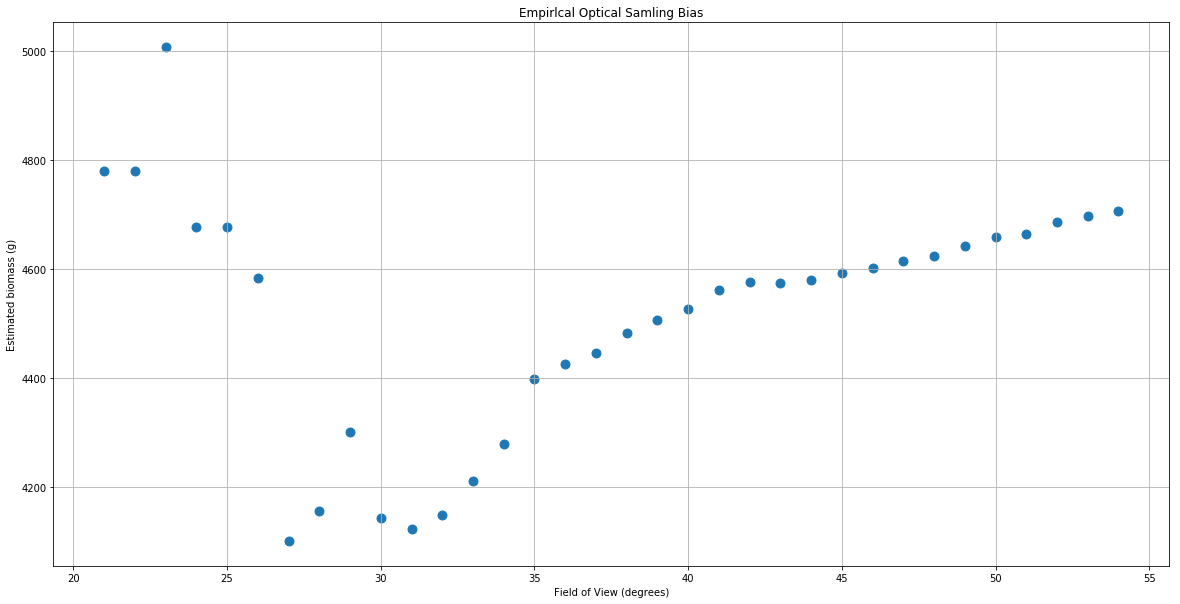

In [678]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, pred_weight_means, s=80)
plt.xlabel('Field of View (degrees)')
plt.ylabel('Estimated biomass (g)')
plt.title('Empirlcal Optical Samling Bias')
plt.grid()
plt.show()



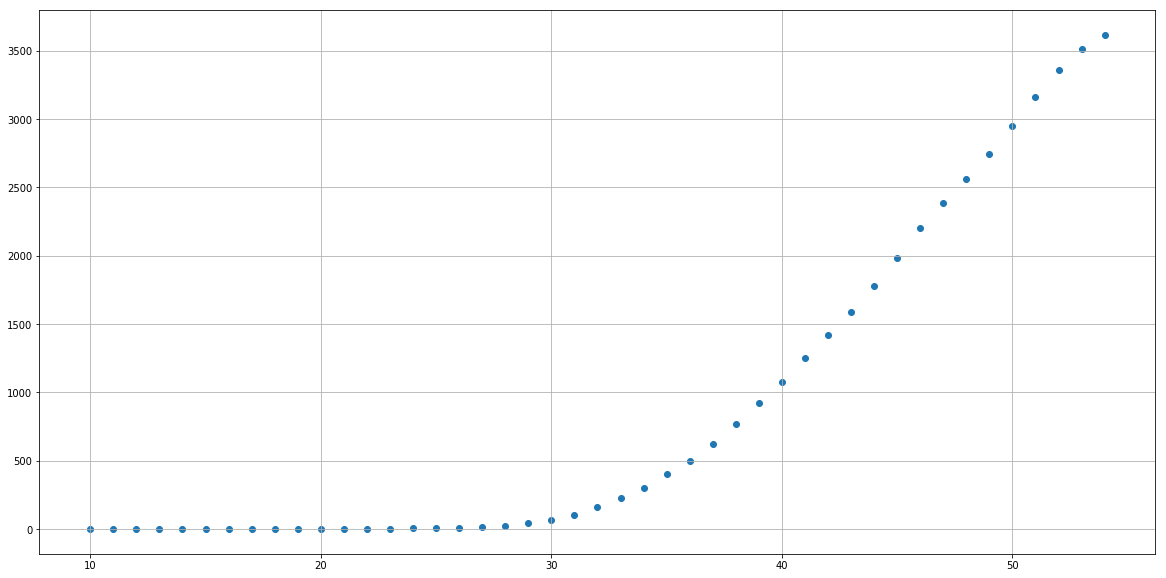

In [679]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, sample_sizes)
plt.grid()
plt.show()



<h1> Waiting pen ID #2 </h1>

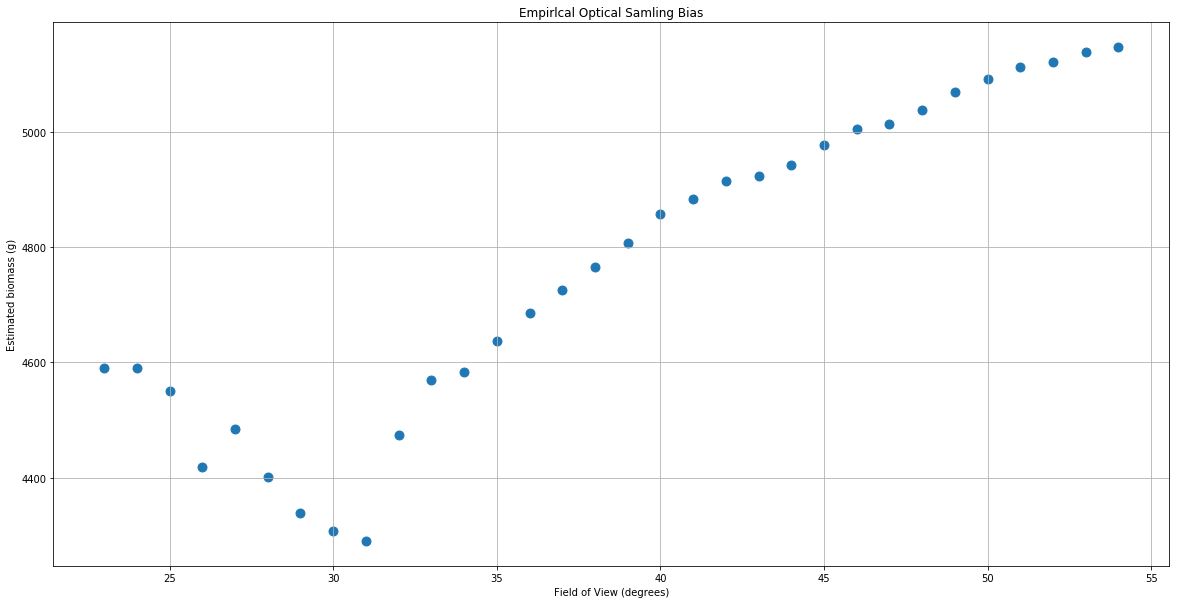

In [670]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, pred_weight_means, s=80)
plt.xlabel('Field of View (degrees)')
plt.ylabel('Estimated biomass (g)')
plt.title('Empirlcal Optical Samling Bias')
plt.grid()
plt.show()



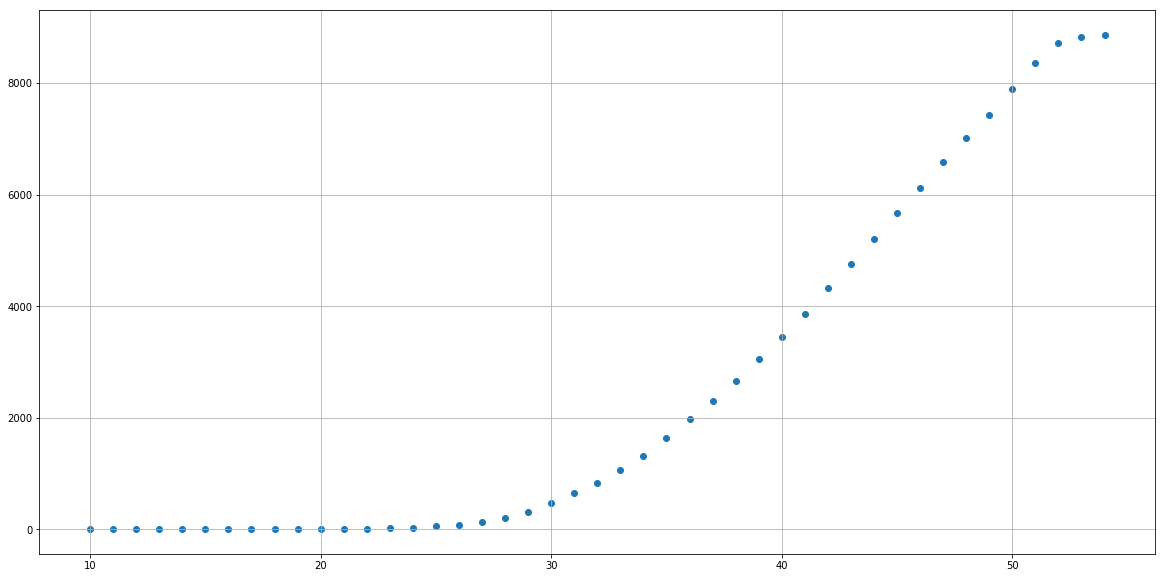

In [642]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, sample_sizes)
plt.grid()
plt.show()



<h1> Waiting Pen ID #3 </h1>

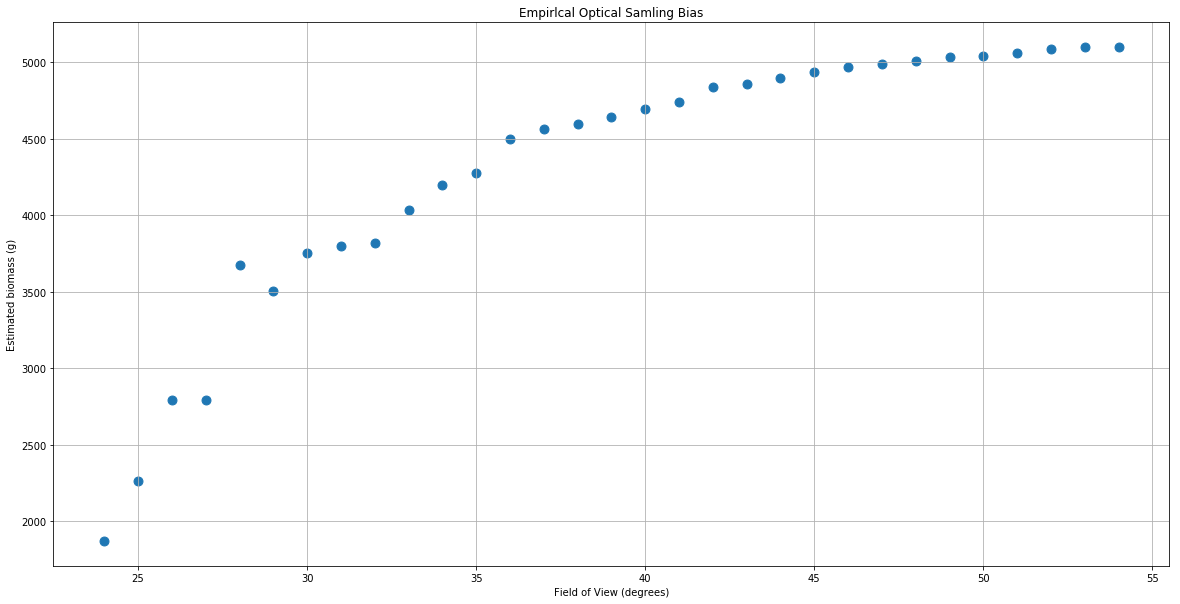

In [687]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, pred_weight_means, s=80)
plt.xlabel('Field of View (degrees)')
plt.ylabel('Estimated biomass (g)')
plt.title('Empirlcal Optical Samling Bias')
plt.grid()
plt.show()



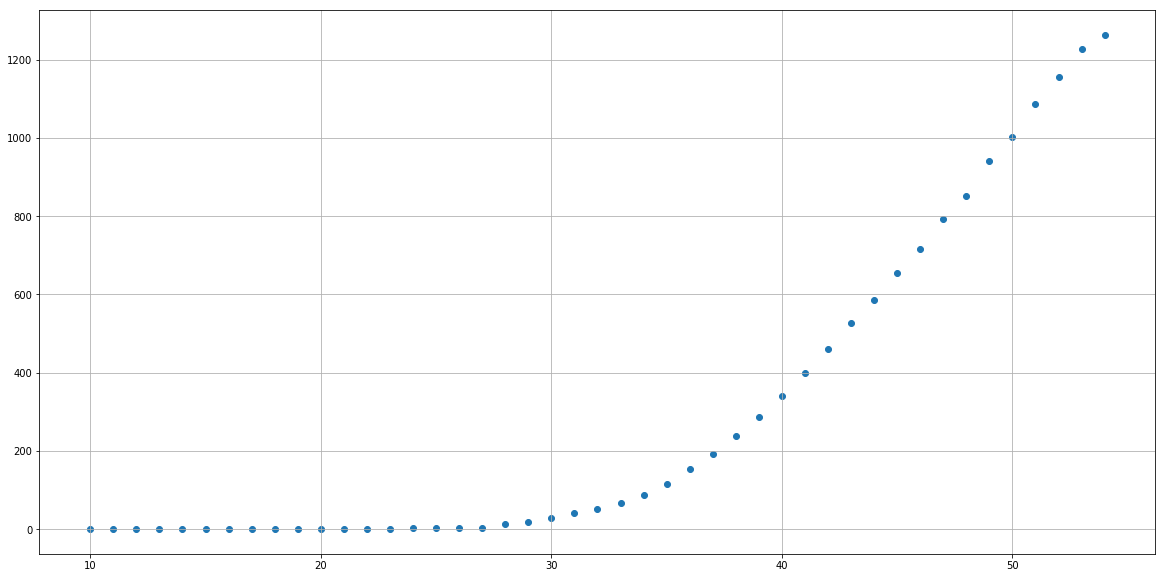

In [688]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, sample_sizes)
plt.grid()
plt.show()



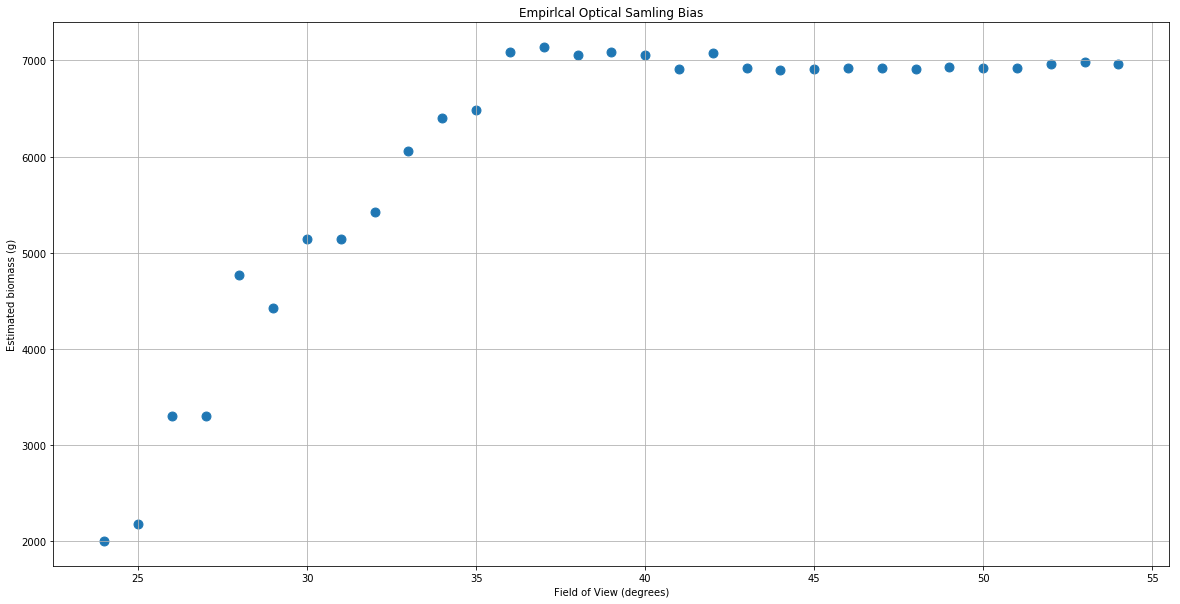

In [696]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, pred_weight_means, s=80)
plt.xlabel('Field of View (degrees)')
plt.ylabel('Estimated biomass (g)')
plt.title('Empirlcal Optical Samling Bias')
plt.grid()
plt.show()



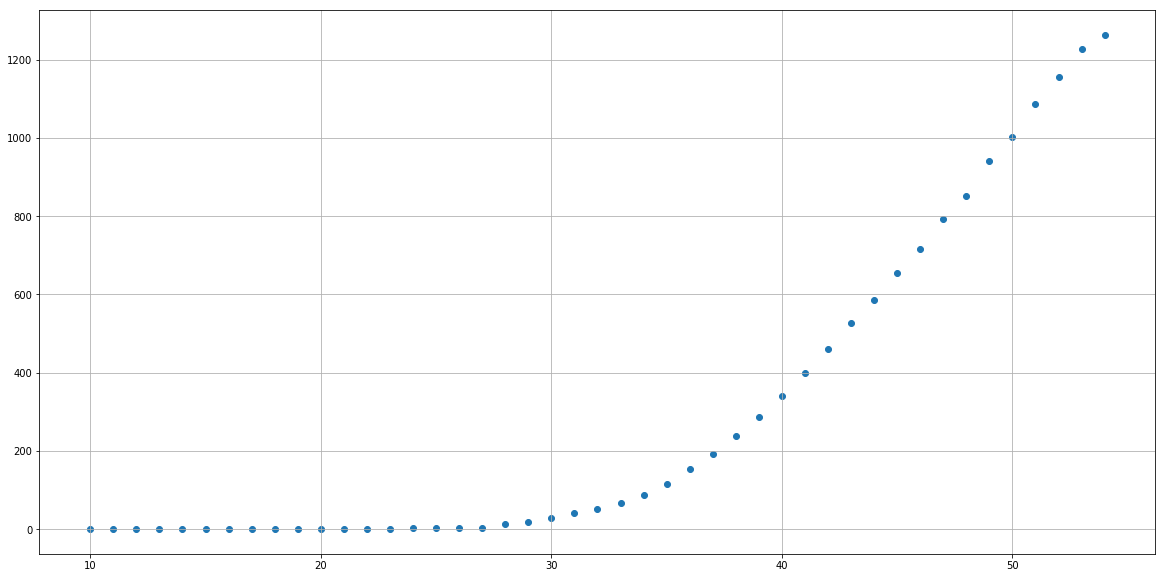

In [697]:
plt.figure(figsize=(20, 10))
plt.scatter(fovs, sample_sizes)
plt.grid()
plt.show()



In [639]:
tdf[tdf.depth > 1.75].est_weight.mean()

0.4771881667168244

In [617]:
tdf[tdf.is_preserved_29 == True]

,id,fish_detection_id,annotated_by_email,is_qa,is_skipped,is_blurry,is_dark,is_occluded,is_bad_orientation,is_partial,...,is_preserved_47,is_preserved_48,is_preserved_49,is_preserved_50,is_preserved_51,is_preserved_52,is_preserved_53,is_preserved_54,est_weight,depth
5,856476,None,bati19@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.454373,1.870442
48,858673,None,bati19@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.698261,1.812508
63,859194,None,bati8@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.845321,1.969360
93,856496,None,bati1@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.388409,1.665150
111,858022,None,bati18@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.641769,1.812508
119,858709,None,bati4@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.398618,1.638507
121,856279,None,bati15@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.294890,1.651721
650,855775,None,bati10@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.340536,1.606380
1044,854035,None,bati8@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.464029,1.575488
1199,567261,None,bati14@cogitotech.com,False,False,None,None,None,None,None,...,True,True,True,True,True,True,True,True,0.530580,1.128448
